# CINEMA-OT

In this tutorial, we demonstrate how to use CINEMA-OT to reveal the perturbation effect induced by IFNb treatment on PBMC immune cells. We provide a minimal example dataset (1000 cells) that reproduces consistent results in the [paper](https://www.biorxiv.org/content/10.1101/2022.07.31.502173v3) (Figure 5E). This tutorial can be run on personal computer in ~2 minutes.

# 1. Loading packages and data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import pertpy as pt
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Arial'
plt.rcParams['figure.dpi'] = 250

Global seed set to 0
/opt/homebrew/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
/opt/homebrew/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
/opt/homebrew/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.


In [ ]:
adata = pt.dt.cinemaot_example()

In [3]:
adata

AnnData object with n_obs × n_vars = 1000 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'cf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

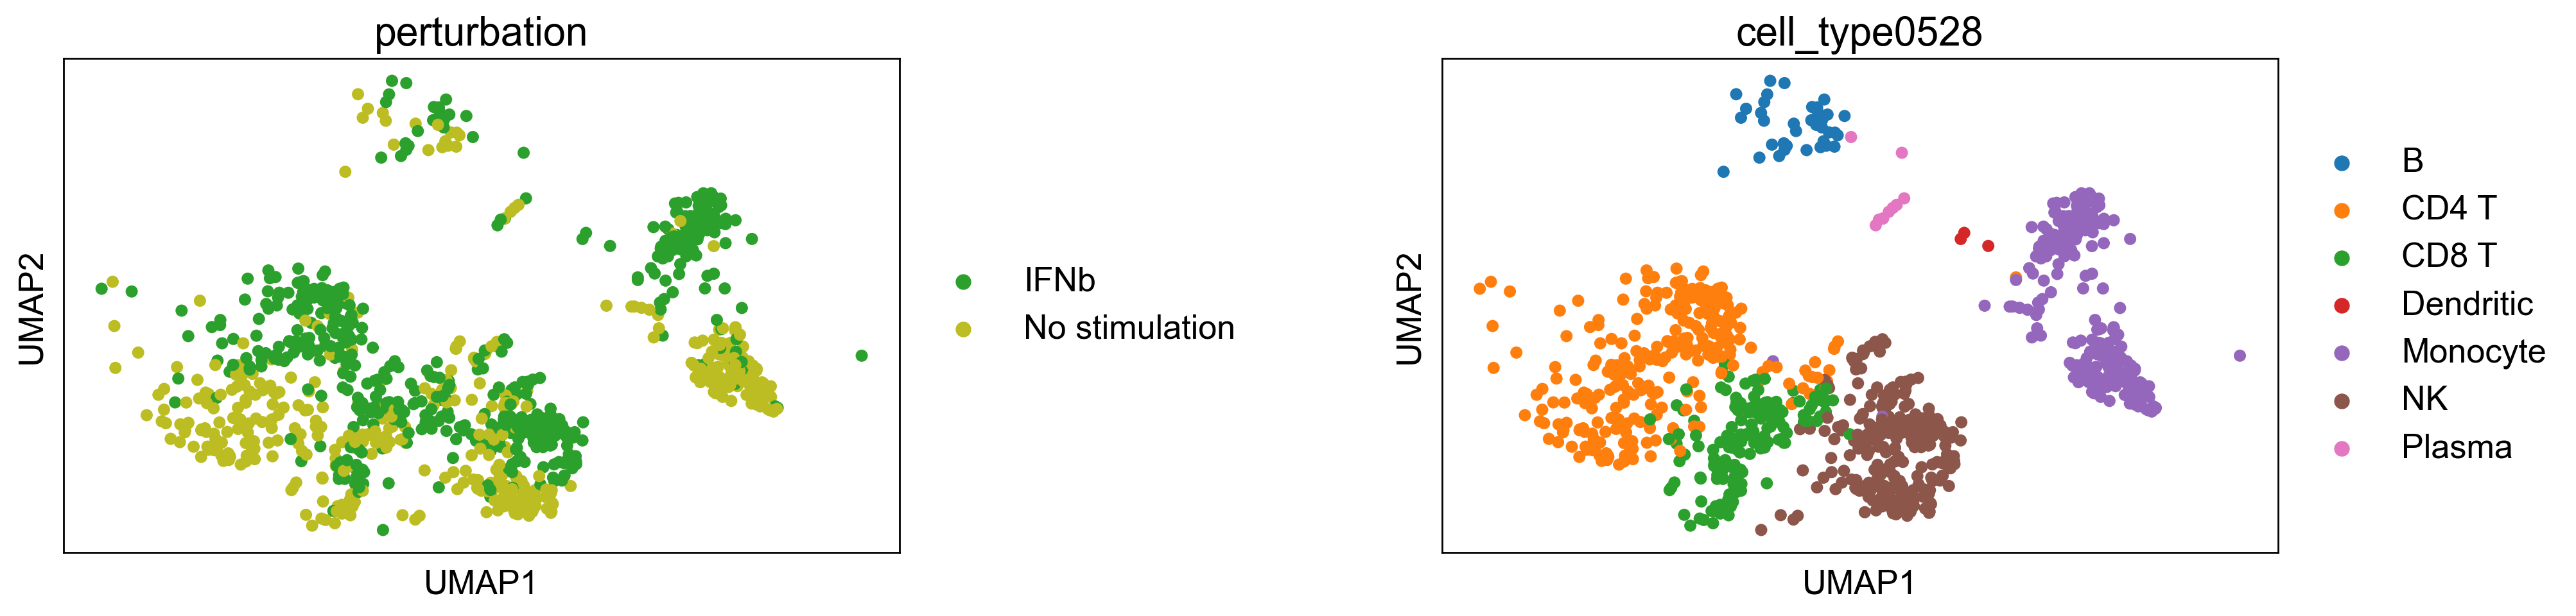

In [5]:
plt.rcParams["font.family"] = 'Arial'
plt.rcParams['figure.dpi'] = 250
plt.rcParams["font.size"] = 15
sc.pl.umap(adata,color=['perturbation','cell_type0528'],wspace=0.5)

# 2. CINEMA-OT treatment effect analysis

First we perform CINEMA-OT analysis applying the annotated cell type label. CINEMA-OT returns a confounder embedding in the original `adata.obsm['cf']`, and a new anndata object `de` that includes the single-cell level treatment effect matrix `de.X`, and the low dimensional embedding `de.obsm['X_embedding']`. If `return_matching is set to True, the model also returns the matching matrix in `de.obsm['ot']`.

In [6]:
model = pt.tl.Cinemaot()
sc.pp.pca(adata)
de = model.causaleffect(adata,pert_key='perturbation', control='No stimulation',return_matching=True,thres=0.5,smoothness=1e-5,eps=1e-3,solver='Sinkhorn',preweight_label='cell_type0528')

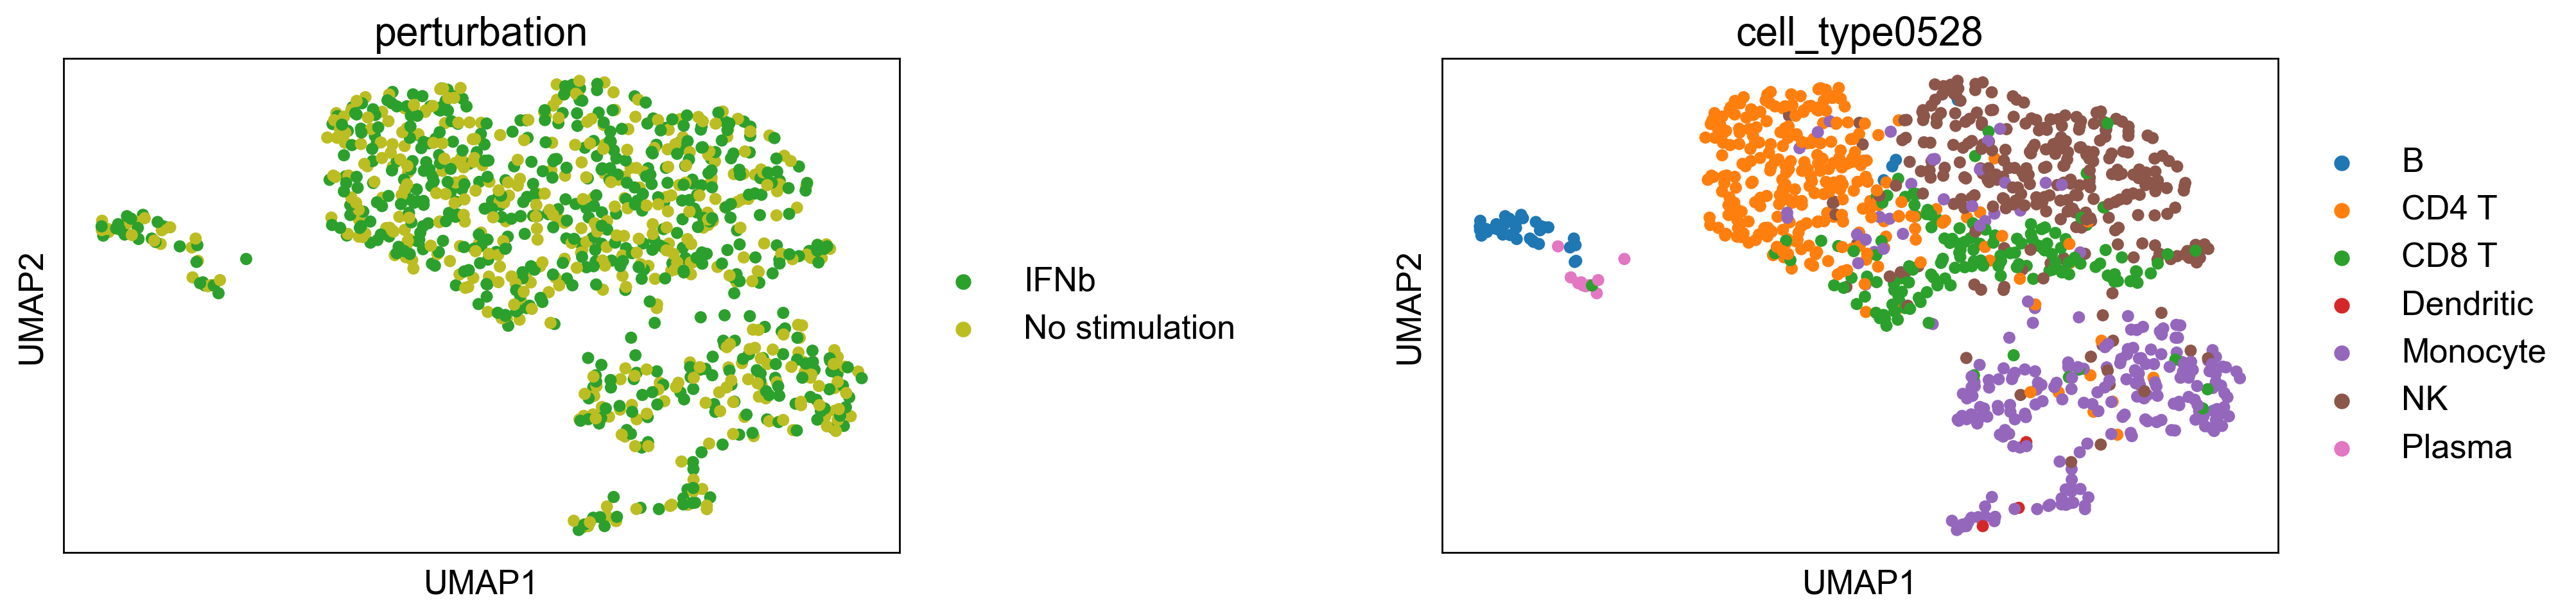

In [7]:
sc.pp.neighbors(adata,use_rep='cf')
sc.tl.umap(adata,random_state=1)
sc.pl.umap(adata,color=['perturbation','cell_type0528'],wspace=0.5)

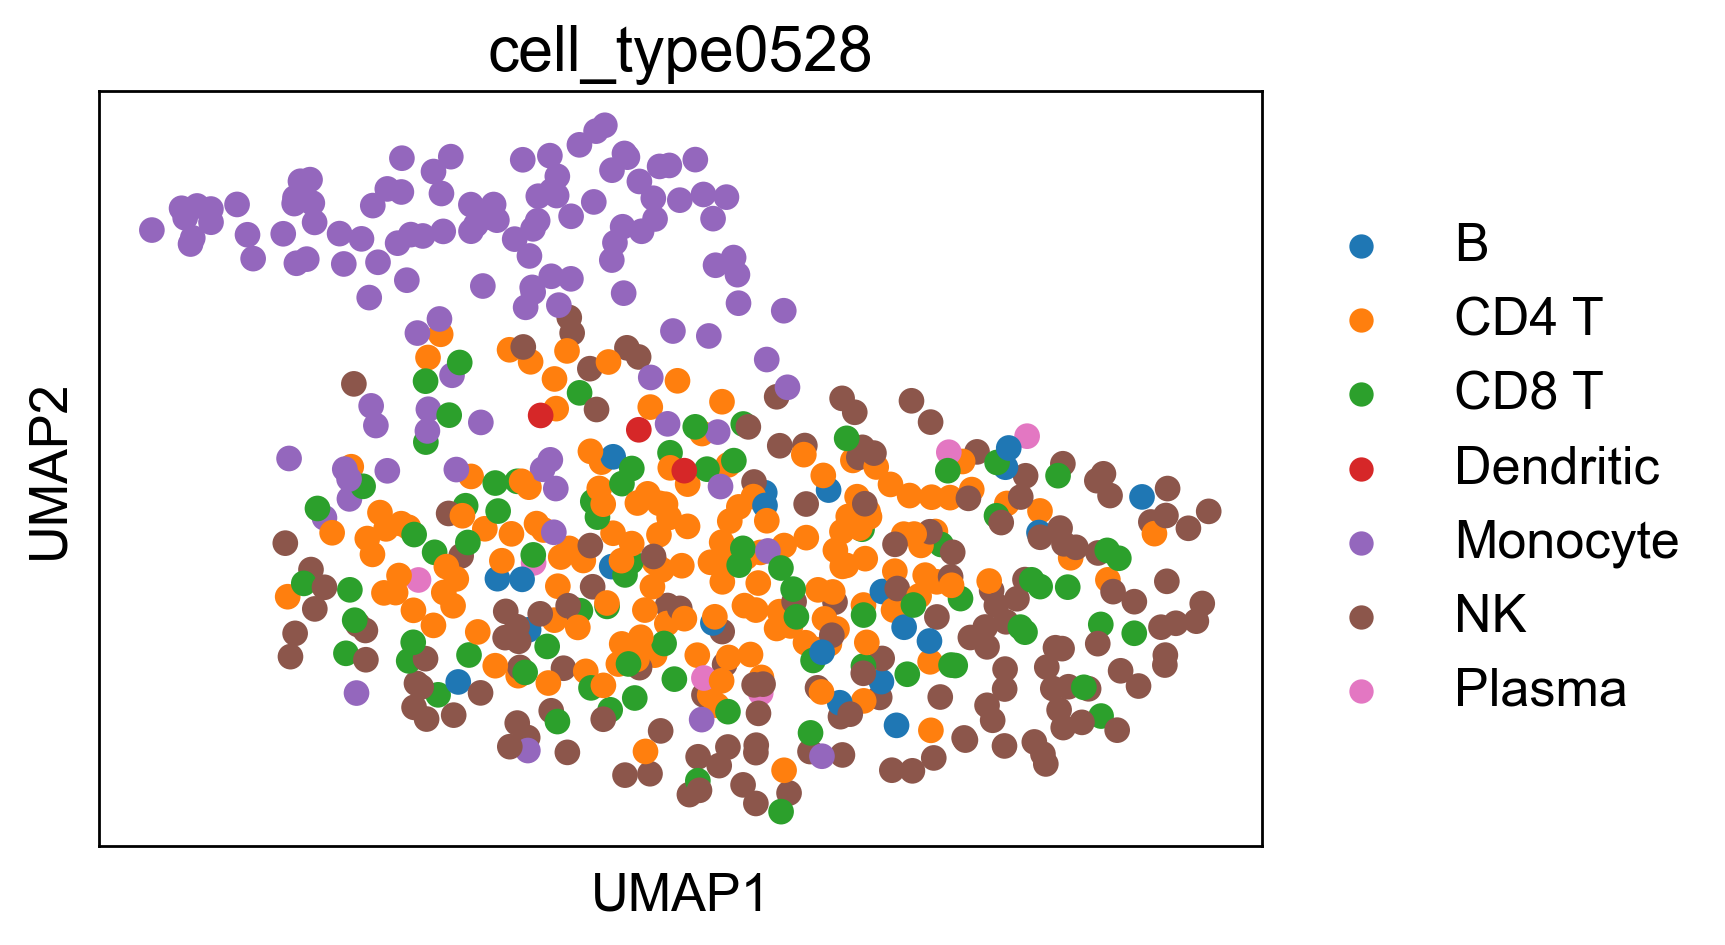

In [8]:
sc.pp.neighbors(de,use_rep='X_embedding')
sc.tl.umap(de)
sc.pl.umap(de,color=['cell_type0528'])

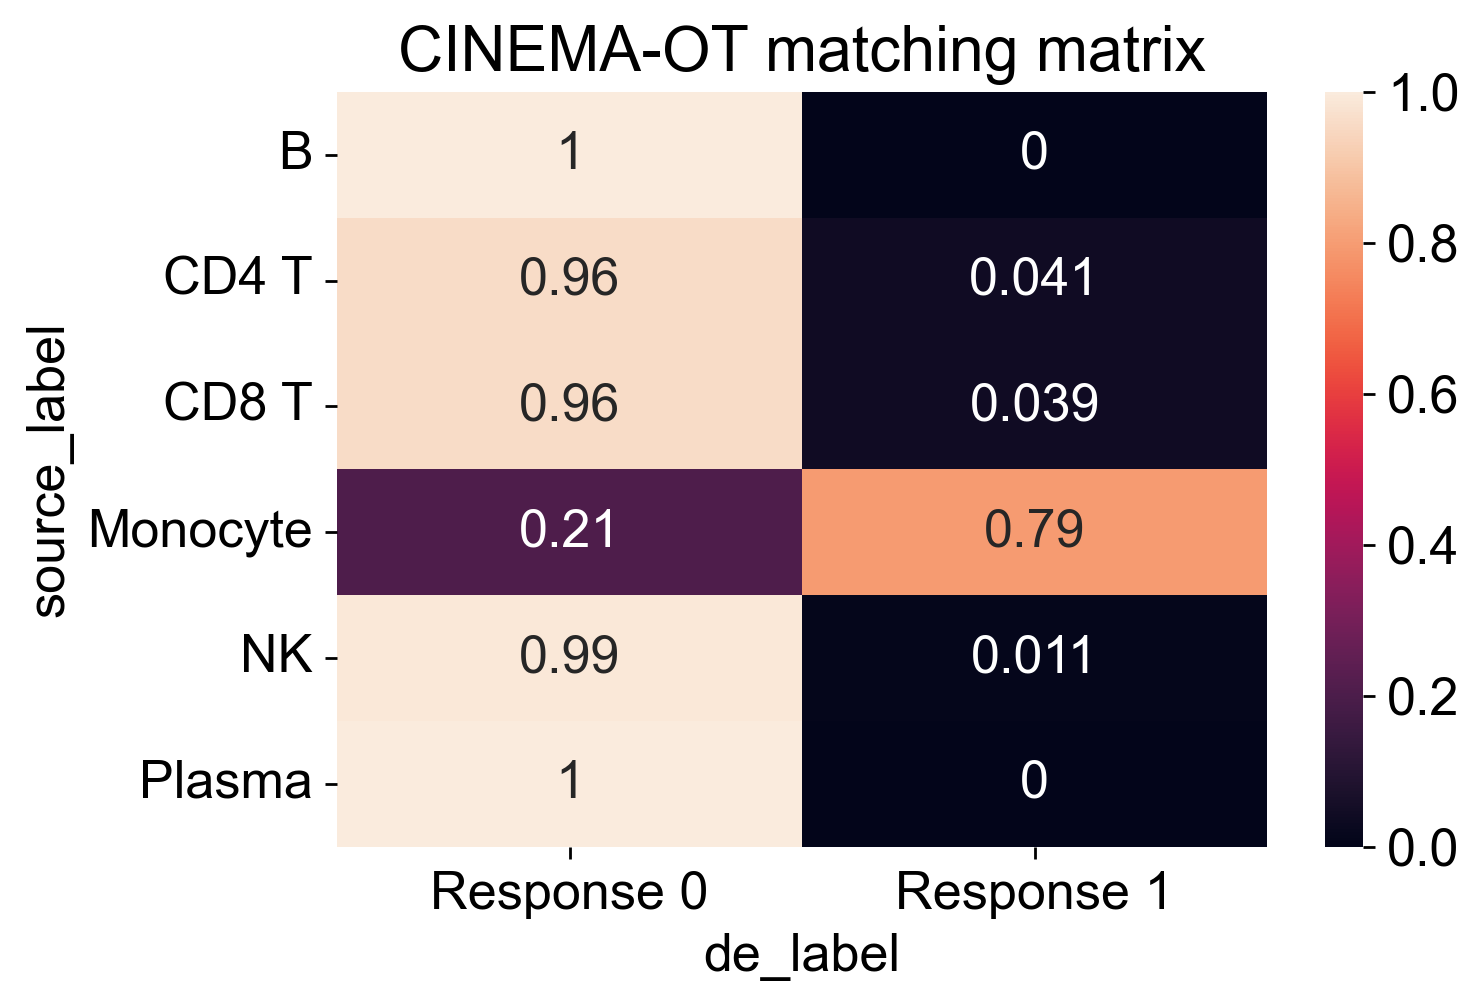

In [13]:
plot = pt.pl.cot()
plot.vis_matching(adata,de,pert_key='perturbation',control='No stimulation',de_label=None,source_label='cell_type0528',normalize='row',min_val=0.05)

Then we perform CINEMA-OT analysis using the CINEMA-OT-W approach. This approach unsupervisedly estimate the confounder abundance and return the subsampled adata as well as the corresponding treatment effect anndata. The format of output is consistent with the original approach above. We see in practice the approach generates very similar results compared with the result above with prior annotated cell type labels.

In [15]:
model = pt.tl.Cinemaot()
sc.pp.pca(adata)
ad, de = model.causaleffect_weighted(adata,pert_key='perturbation', control='No stimulation',return_matching=True,thres=0.5,smoothness=1e-5,eps=1e-3,solver='Sinkhorn')

/Users/guardian/Desktop/cinemaot_test/CINEMA-OT-main/pertpy/pertpy/tools/_cinemaot.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


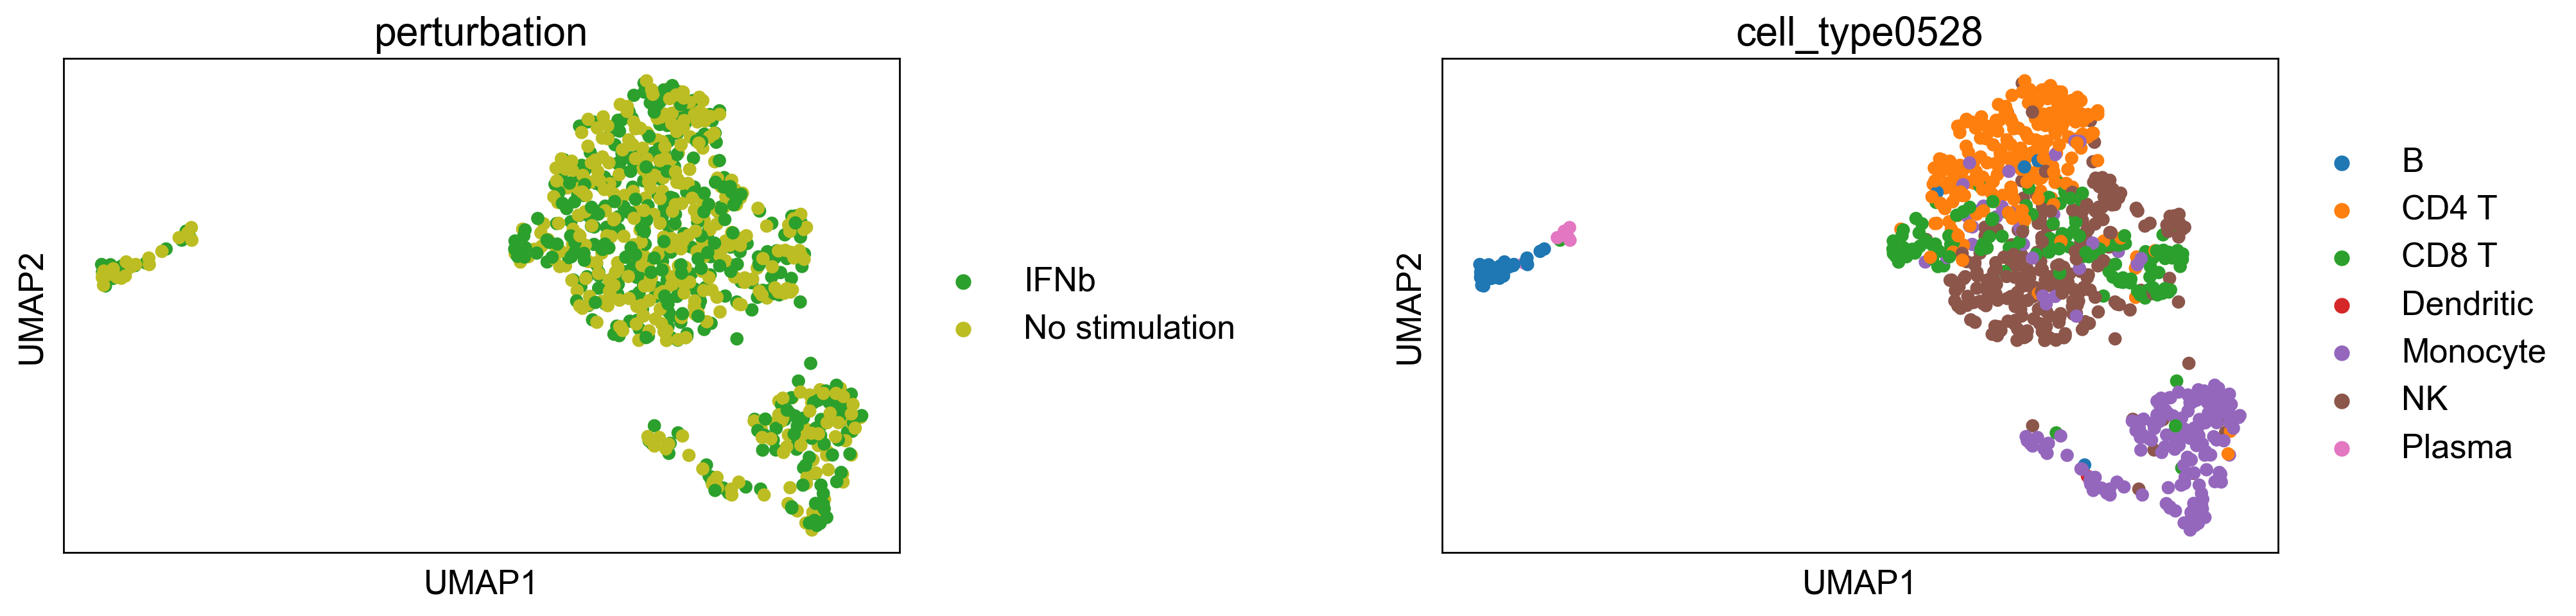

In [17]:
sc.pp.neighbors(ad,use_rep='cf')
sc.tl.umap(ad,random_state=1)
sc.pl.umap(ad,color=['perturbation','cell_type0528'],wspace=0.5)

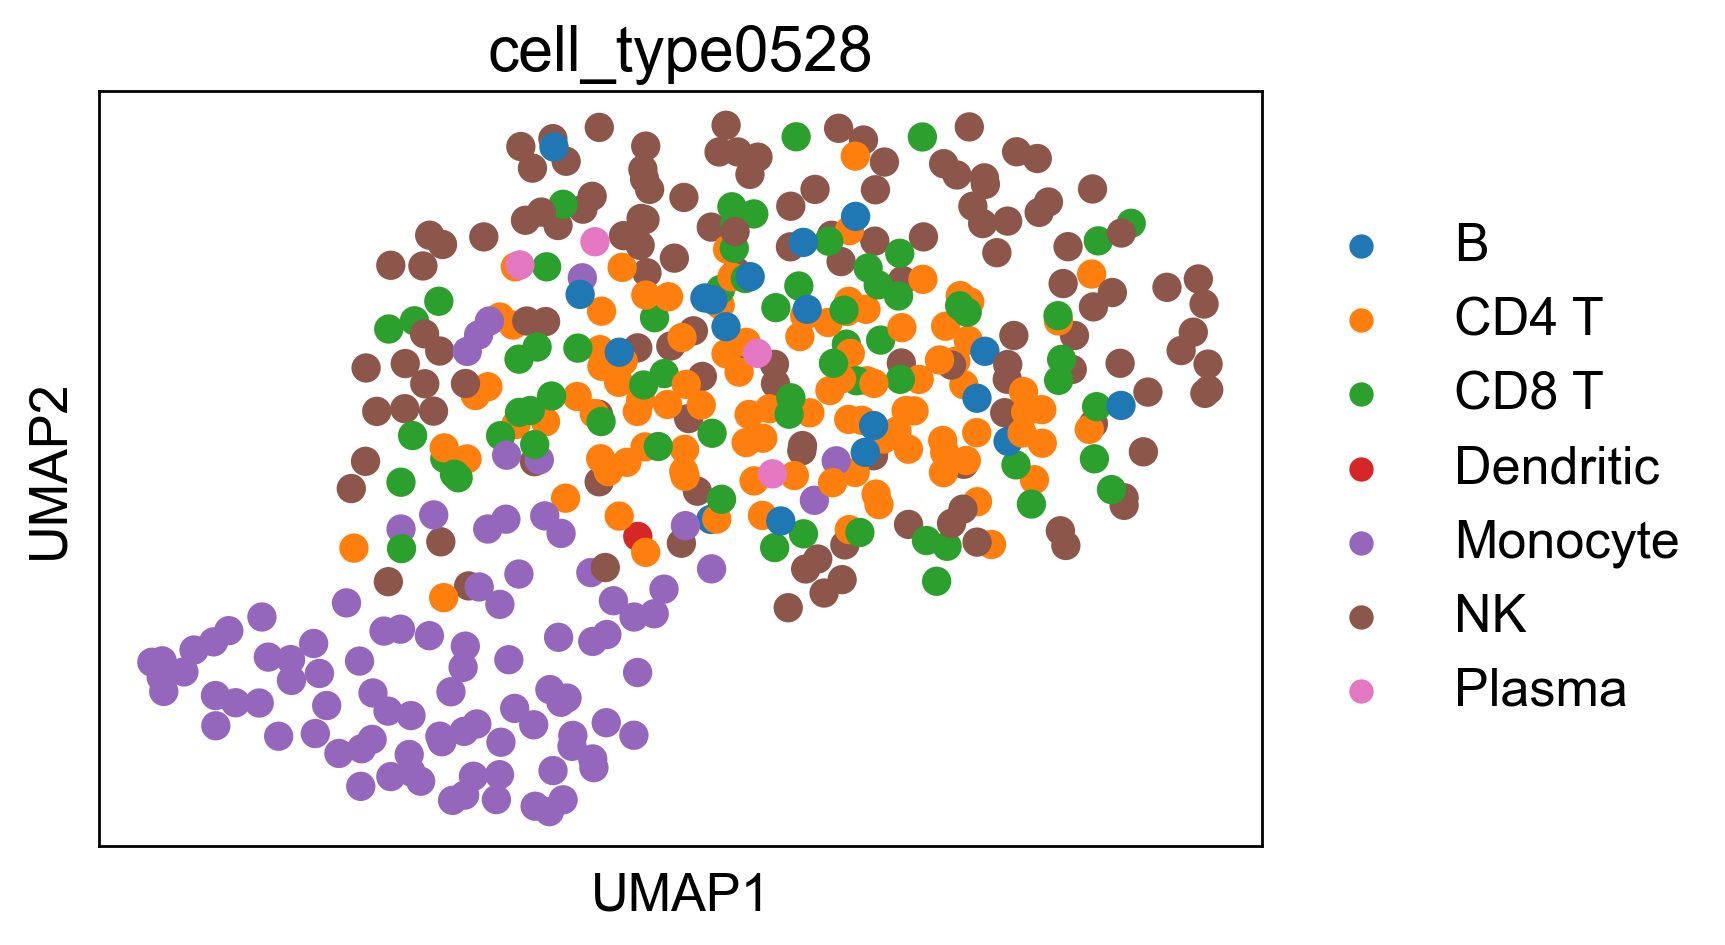

In [18]:
sc.pp.neighbors(de,use_rep='X_embedding')
sc.tl.umap(de)
sc.pl.umap(de,color=['cell_type0528'])

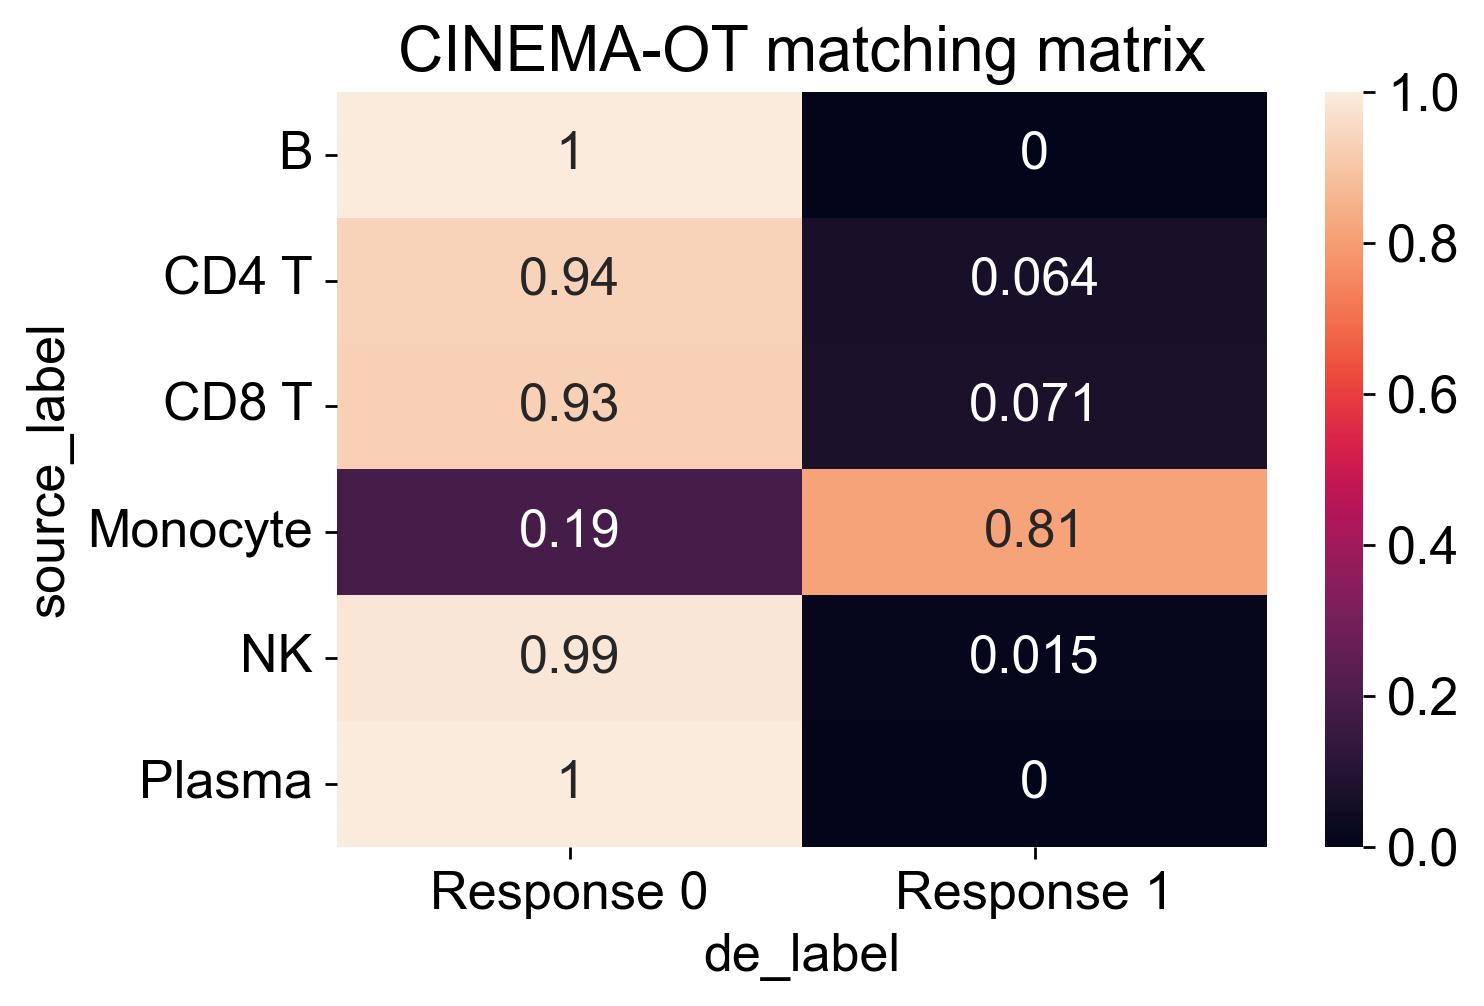

In [19]:
plot = pt.pl.cot()
plot.vis_matching(ad,de,pert_key='perturbation',control='No stimulation',de_label=None,source_label='cell_type0528',normalize='row',min_val=0.05)

The minimal dataset only includes two pairwise conditions (IFNb, control). In the case with combinatorial perturbations, the function Cinemaot.synergy provides a wrapper for returning the synergy anndata syn with metadata and the low dimensional embedding stored in syn.obsm['X_embedding'].

# 3. Generating pseudobulk profiles by CINEMA-OT

In this implementation, given the emerging need of analyzing cohort level scRNA-seq data, we also provide a highly customized function that enables generating pseudobulk profiles accounting the possible heterogenous treatment effect space. The pseudobulk profiles are aggregated by the confounder space (or other given metadata labels in label_list) and the treatment effect space clustering. The intuition is that all covariates apart from the treatment should be well modeled by the CINEMA-OT confounder space.

In [25]:
model = pt.tl.Cinemaot()
de = model.causaleffect(adata,pert_key='perturbation', control='No stimulation',return_matching=True,thres=0.5,smoothness=1e-5,eps=1e-3,solver='Sinkhorn',preweight_label='cell_type0528')
adata_pb = model.generate_pseudobulk(adata,de,pert_key='perturbation', control='No stimulation',label_list=None)
adata_pb

/Users/guardian/Desktop/cinemaot_test/CINEMA-OT-main/pertpy/pertpy/tools/_cinemaot.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AnnData object with n_obs × n_vars = 20 × 773
    obs: 'ct', 'ptb'